In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pydot

from io import StringIO
from sklearn.tree import export_graphviz, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from IPython.display import Image, display

Populating the interactive namespace from numpy and matplotlib


# Titanic Survival Dataset

* [데이터 다운로드 및 설명 링크](https://www.kaggle.com/c/titanic/data)

In [2]:
def get_raw_dataset():
    # Preprocessing Raw Dataset
    train_df = pd.read_csv('train.csv')
#     train_df.dropna(inplace=True)
    
    columns = ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    y_train = np.array(train_df['Survived'])
    x_train = train_df[columns]
    
    # Convert Datatype
    # x_train['Sex'].astype('category', inplace=True)
    # x_train['Embarked'].astype('category', inplace=True)
    
    return x_train, y_train
    
x_train, y_train = get_raw_dataset()

# Missing Value
print('Missing Values')
display(x_train.isna().sum())

print('shape:', x_train.shape)
x_train.head()

Missing Values


Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

shape: (891, 6)


,Sex,Age,SibSp,Parch,Fare,Embarked
0,male,22.0,1,0,7.2500,S
1,female,38.0,1,0,71.2833,C
2,female,26.0,0,0,7.9250,S
3,female,35.0,1,0,53.1000,S
4,male,35.0,0,0,8.0500,S


# Decision Tree Model

## Preprocessing
 
 - Sex
   - Female: 0
   - Male: 1
 - Age 
   - Missing value: 평균값 사용 
 - Embarked 
   - Missing value: mode 사용 (가장 빈도수가 많은 값)

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

x_train, y_train = get_raw_dataset()


# Missing Values
x_train['Age'].loc[x_train['Age'].isna()] = x_train['Age'].mean()
x_train['Embarked'].loc[x_train['Embarked'] == None] = x_train['Embarked'].mode()

# Encoding
label_encoder = LabelEncoder()
x_train = pd.get_dummies(x_train, columns=['Embarked'])
x_train['Sex'] = label_encoder.fit_transform(x_train['Sex'])


print('[Training Data]')
display(x_train.head())

[Training Data]


,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,1,22.0,1,0,7.2500,0,0,1
1,0,38.0,1,0,71.2833,1,0,0
2,0,26.0,0,0,7.9250,0,0,1
3,0,35.0,1,0,53.1000,0,0,1
4,1,35.0,0,0,8.0500,0,0,1


## Model & Training

In [4]:
# Train
clf = DecisionTreeClassifier(max_depth=8)
clf = clf.fit(x_train, y_train)

# Validation on Train data
y_pred = clf.predict(x_train)
print('[Classification Report]')
print(classification_report(y_train, y_pred))

[Classification Report]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       549
           1       0.87      0.78      0.82       342

    accuracy                           0.87       891
   macro avg       0.87      0.85      0.86       891
weighted avg       0.87      0.87      0.87       891



# Tree Analysis


## Visualization

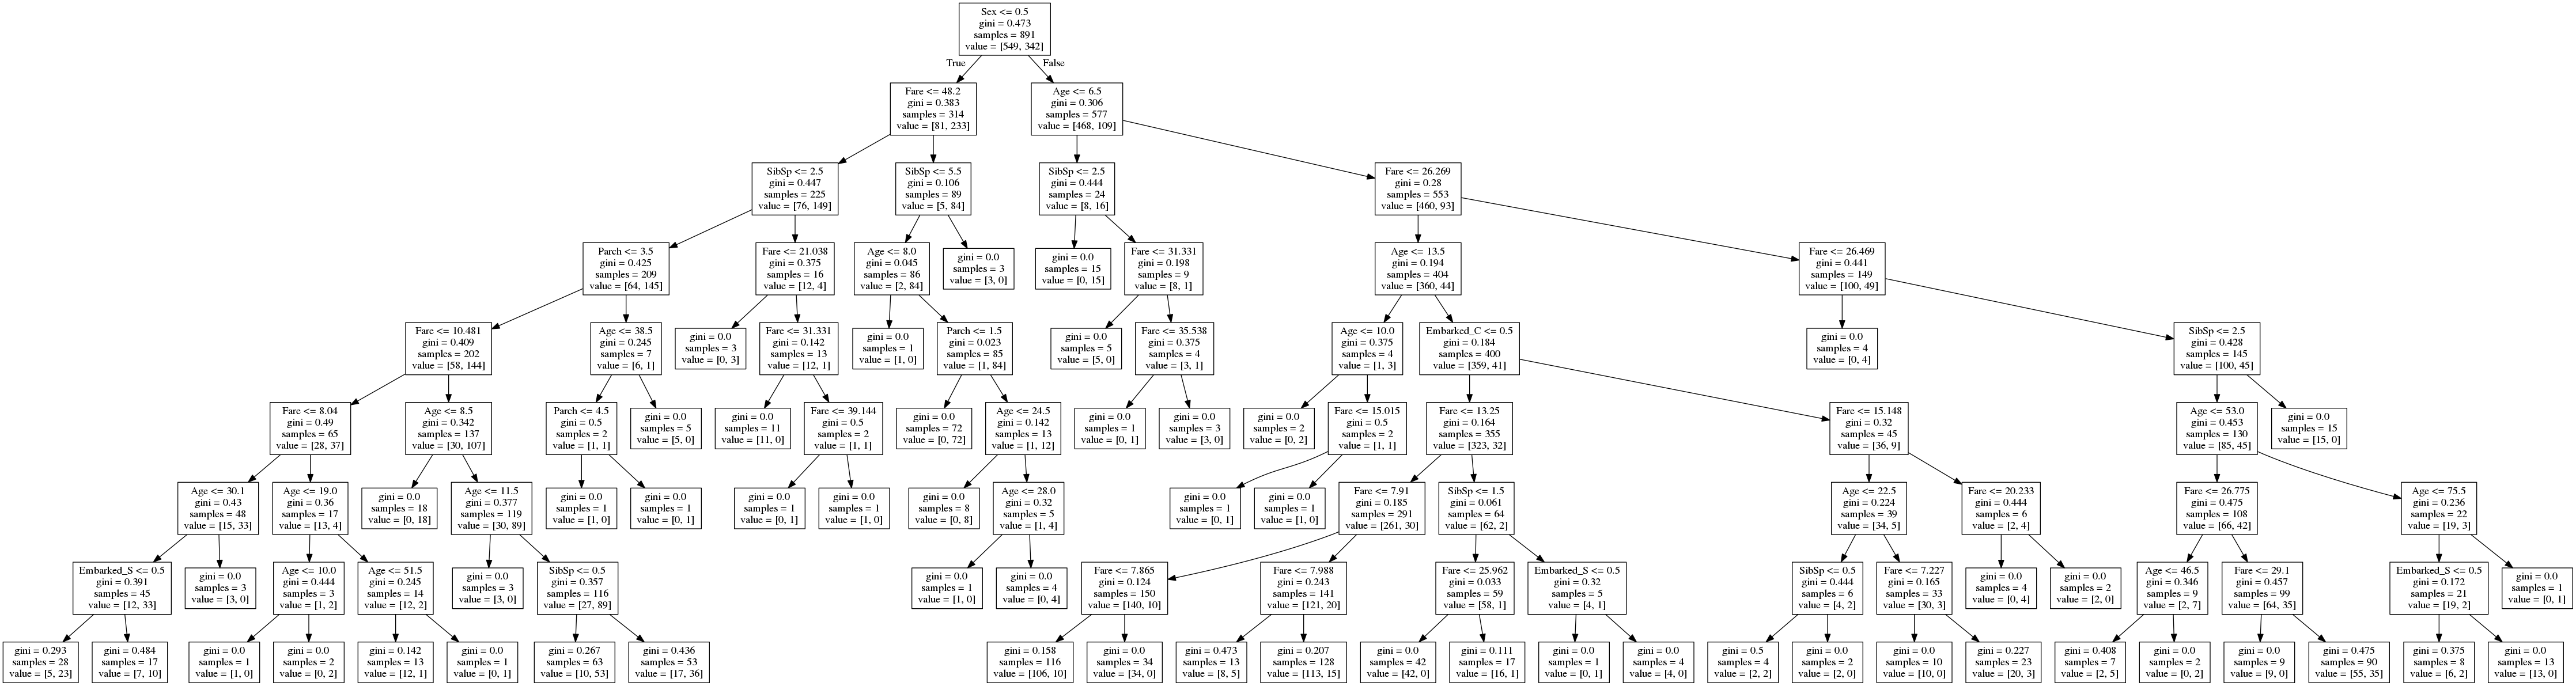

In [5]:
from io import StringIO
from sklearn.tree import export_graphviz, plot_tree

f = StringIO()
export_graphviz(clf, out_file=f,
                feature_names=x_train.columns.tolist())
graph = pydot.graph_from_dot_data(f.getvalue())[0]
graph.write_png('titanic_decision_tree.png')
Image(filename='titanic_decision_tree.png')

## Decision Path

어떤 데이터가 모델의 input으로 들어왔을때, 어떤 의사결정으로 tree를 traversal했는지 알기 위해서는 다음과 같이 합니다.<br>
1은 traversal 한 노드이고, 0은 지나가지 않은 자리 입니다.

In [6]:
x_sample = x_train.sample(1)

dp = clf.decision_path(x_sample).todense()
dp

matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])

## 사용한 Features 얻는 방법

트리 구조 안에서의 features 정보를 얻는 방법은 다음과 같이 합니다.

In [7]:
from sklearn.tree._tree import TREE_UNDEFINED
columns = x_train.columns

features = np.array(columns[clf.tree_.feature])
features[clf.tree_.feature == TREE_UNDEFINED] = None
features

array(['Sex', 'Fare', 'SibSp', 'Parch', 'Fare', 'Fare', 'Age',
       'Embarked_S', None, None, None, 'Age', 'Age', None, None, 'Age',
       None, None, 'Age', None, 'Age', None, 'SibSp', None, None, 'Age',
       'Parch', None, None, None, 'Fare', None, 'Fare', None, 'Fare',
       None, None, 'SibSp', 'Age', None, 'Parch', None, 'Age', None,
       'Age', None, None, None, 'Age', 'SibSp', None, 'Fare', None,
       'Fare', None, None, 'Fare', 'Age', 'Age', None, 'Fare', None, None,
       'Embarked_C', 'Fare', 'Fare', 'Fare', None, None, 'Fare', None,
       None, 'SibSp', 'Fare', None, None, 'Embarked_S', None, None,
       'Fare', 'Age', 'SibSp', None, None, 'Fare', None, None, 'Fare',
       None, None, 'Fare', None, 'SibSp', 'Age', 'Fare', 'Age', None,
       None, 'Fare', None, None, 'Age', 'Embarked_S', None, None, None,
       None], dtype=object)

dp 그리고 features 값을 사용해서 어떤 features를 사용했는지는 다음의 코드로 알 수 있습니다.<br>
마지막의 None값은 leaf node이기 때문에 None값이 나옵니다.

해석을 다양하게 할 수 있습니다. 

 1. 앞쪽에 있을수록 종속 변수 y값에 가장 크게 영향을 미치는 feature
 2. 많이 사용된 features일수록 tree구조 안에서 y값에 영향을 주는 정도가 커진다
 
 2개중에서 1번의 중요도가 더 중요합니다. 


## Feature Importance

Feature Importance를 봐도 어떤것을 중요하게 봐야 할지 알 수 있습니다. <br>

In [23]:
columns = x_train.columns
iters = zip(clf.feature_importances_, columns[np.argsort(clf.feature_importances_)[::-1]])
df = pd.DataFrame([[c, sum(features == c), fi] for fi, c in iters], 
             columns=['feature', 'n_use', 'importance'])
df.sort_values('importance', ascending=False, inplace=True)
df

,feature,n_use,importance
0,Sex,1,0.488732
4,Parch,3,0.224303
1,Fare,21,0.146175
2,Age,17,0.102061
3,SibSp,7,0.021709
7,Embarked_Q,0,0.013235
5,Embarked_S,3,0.003787
6,Embarked_C,1,0.000000


## Cause Analysis by Decision Path


In [24]:
from sklearn.tree._tree import TREE_UNDEFINED
from pprint import pprint

def get_decision_path(data, columns):
    features = np.array(columns[clf.tree_.feature])
    features[clf.tree_.feature == TREE_UNDEFINED] = None
    
    dp = clf.decision_path(data)
    n = dp.shape[0]
    
    response = []
    for i in range(n):
        node_indices = dp.indices[dp.indptr[i]: dp.indptr[i + 1]]
        
        node_features = features[node_indices][:-1]
        node_thresholds = clf.tree_.threshold[node_indices][:-1].round(2)
        causes = list(zip(node_features, node_thresholds))
        causes = [[f, t, data[f].values[0] <= t] for f, t in causes]
        response.append(causes)
    return response
        
    
columns = np.array(x_train.columns)
x_sample = x_train.sample(1)
y_sample = y_train[x_sample.index]
decision_pathes = get_decision_path(x_sample, columns)

display(list(np.where(y_sample, '살았음', '죽었음')))
pprint(decision_pathes)

['죽었음']

[[['Sex', 0.5, True], ['Fare', 48.2, False], ['SibSp', 5.5, False]]]



위의 내용만 갖고서는 사실 요점을 잘 이해하기 어려울수 있습니다. <br>
아래의 코드는 threshold의 기준점을 잘라서 보여주는 코드입니다.

In [25]:
def _agg_decision_path(df):
    df1 = df[df['is_lower']].groupby('feature').min()
    df2 = df[~df['is_lower']].groupby('feature').max()

    df3 = df.groupby('feature').count()[['priority']]
    df3 = df2.join(df1, how='outer', rsuffix='_b').join(
        df3, how='outer', rsuffix='_c')
    df3['priority'] = np.nanmin(
        df3[['priority', 'priority_b', 'priority_c']].values[0])
    df3['value'] = np.nanmin(df3[['value', 'value_b']].values[0])

    df3 = df3[['priority', 'priority_c', 'threshold', 'value', 'threshold_b']]
    df3.columns = ['priority', 'count',
                   'threshold_less', 'value', 'threshold_more']
    df3.reset_index(drop=True, inplace=True)

    return df3


def summary_decision_path(decision_pathes, x_data, y_data):
    response = []
    
    # Set Feature Importances
    arg_feature_importances = np.argsort(clf.feature_importances_)[::-1]
    f_impt = pd.DataFrame({'feature': np.array(columns[arg_feature_importances]),
                           'importance': clf.feature_importances_[arg_feature_importances]})
    f_impt.set_index('feature', inplace=True)
    
    for i, dp in enumerate(decision_pathes):
        # Preprocess X data
        x_sample = x_data.iloc[i:i+1].T
        x_sample.reset_index(inplace=True)
        idx = x_sample.columns[1]
        x_sample.columns = ['feature', 'value']

        # Preprocess Decision Path
        df = pd.DataFrame(dp, columns=['feature', 'threshold', 'is_lower'])
        df = df.merge(x_sample, left_on='feature', right_on='feature')
        df.reset_index(inplace=True)
        df.rename({'index': 'priority'}, axis=1, inplace=True)
        df = df.groupby('feature').apply(_agg_decision_path)
        df.index = df.index.get_level_values(0)
        df = df.join(f_impt, how='left')
        df = df.sort_values('importance', ascending=False)
        df.insert(0, 'idx', idx)
        if y_data is not None:
            df.insert(1, 'y_true', y_data[i])
        response.append(df)
    return pd.concat(response)


summary_decision_path(decision_pathes, x_sample, y_sample)

,idx,y_true,priority,count,threshold_less,value,threshold_more,importance
feature,,,,,,,,
Sex,180,0,0.0,1,NaN,0.00,0.5,0.488732
Fare,180,0,1.0,1,48.2,69.55,NaN,0.224303
SibSp,180,0,1.0,1,5.5,8.00,NaN,0.102061


## What IF Analysis

what if 툴이 있고, 여기서 영감을 받아서 what if analysis라고 이름을 지었습니다. <br>
어떤 특정 변수를 변화 시켰을때의 확률 값을 계산하는 방법으로, <br>
어떤 값을 변화시켰을때 정말로 큰 요인이 되는지 알아보는 방법입니다.

예를 들어서 성별이 가장 큰 요소 인데, 이것을 변경했을때 예측값이 어떻게 변화되는지 볼 수 있습니다.<br>
실제 남자의 경우 577명중 109명이 생존(18%)했고, 여자의 경우 314명중에서 233명이 생존(74%)했습니다.<br>
만약 죽은 남자들이 여자였다면, 또는 죽은 여자들중에 남자였다면 그 결과가 어떻게 변화 될까요?


일단 사고 희생자중의 성별은 다음과 같습니다.
 - 여자: 81명 
 - 남자: 468명

In [12]:
df = x_train.copy()
df['y'] = y_train
df = df[df['y'] == 0]

In [13]:
y_pred1 = clf.predict(df.drop('y', axis=1))
df['Sex'] = 1 - df['Sex']
y_pred2 = clf.predict(df.drop('y', axis=1))

In [14]:
df2 = pd.DataFrame({'Sex': 1 - df['Sex'], 'before': y_pred1, 'after': y_pred2})
df2.groupby('Sex').agg(['count', np.mean, np.sum])

before               after               
     count      mean sum count      mean  sum
Sex                                          
0       81  0.481481  39    81  0.074074    6
1      468  0.004274   2   468  0.724359  339

위의 코드를 보면 변화된 부분을 알 수 있습니다. 

**여자 -> 남자**

 - 여자 81명중 39명이 생존자라고 예측했으나 -> 남자로 변수를 변경시킨 이후 8명으로 줄었습니다. 
 - 즉 모두 같은 조건에서 성별이 바뀌었다면,  -79% 정도 생존확률이 감소하게 됩니다. 
 
**남자 -> 여자**

 - 남자 468명중 생존자는 2명으로 예측했으나 -> 여자로 변수를 변경시킨 이후 343명으로 생존자가 급격하게 늘었습니다. 
 - 즉 모두 같은 조건에서 성별이 바뀌었다면 약 170%정도 생존확률이 늘어나게 됩니다.